# Attribution patching

In [1]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns

from dawnet.inspector import LLMInspector
from dawnet.tokens import Tokens
from dawnet import op

torch.set_grad_enabled(False)

torch.autograd.grad_mode.set_grad_enabled(mode=False)

In [2]:
LLMInspector._MODELS

{'deepseekv3.2': 'deepseek-ai/DeepSeek-V3.2',
 'gemma-7b': 'google/gemma-7b-it',
 'gemma2-2b': 'google/gemma-2-2b-it',
 'gemma3-4b': 'google/gemma-3-4b-it',
 'gemma3-27b': 'google/gemma-3-27b-it',
 'glm4.6': 'zai-org/GLM-4.6',
 'gptoss-120b': 'openai/gpt-oss-120b',
 'gptoss-20b': 'openai/gpt-oss-20b',
 'mistral3': 'mistralai/Mistral-Large-3-675B-Instruct-2512',
 'ministral3-8b-instruct': 'mistralai/Ministral-3-8B-Instruct-2512',
 'olmo3-7b-base': 'allenai/Olmo-3-1025-7B',
 'olmo3-7b-think-sft': 'allenai/Olmo-3-7B-Think-SFT',
 'olmo3-7b-think-dpo': 'allenai/Olmo-3-7B-Think-DPO',
 'olmo3-7b-think': 'allenai/Olmo-3-7B-Think',
 'olmo3-7b-instruct-sft': 'allenai/Olmo-3-7B-Instruct-SFT',
 'olmo3-7b-instruct-dpo': 'allenai/Olmo-3-7B-Instruct-DPO',
 'olmo3-7b-instruct': 'allenai/Olmo-3-7B-Instruct',
 'olmo3-7b-zero': 'allenai/Olmo-3-7B-RL-Zero-Math',
 'olmo3.1-32b-think': 'allenai/Olmo-3.1-32B-Instruct',
 'qwen3-4b': 'Qwen/Qwen3-4B',
 'qwen3-4b-instruct': 'Qwen/Qwen3-4B-Instruct-2507',
 'qwen3

In [10]:
model_id = "google/gemma-3-4b-it"
insp = LLMInspector.from_hf(LLMInspector._MODELS["olmo3-7b-zero"])

config.json: 0.00B [00:00, ?B/s]

`rope_scaling`'s beta_fast field must be a float, got 32
`rope_scaling`'s beta_slow field must be a float, got 1


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.64G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/69.0 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/581 [00:00<?, ?B/s]

chat_template.jinja:   0%|          | 0.00/430 [00:00<?, ?B/s]

In [3]:
CLEAN_PROMPT = "When John and Mary went to the store, John gave the bag to"
CORRUPTED_PROMPT = "When John and Mary went to the store, Mary gave the bag to"

# this depends on the model
TARGET_TOKEN = 9
CLS_TRUE = 3415
CLS_FALSE = 8712

insp.tokenizer.decode([CLS_TRUE, CLS_FALSE])

' John Mary'

In [4]:
# this depends on the model
name_regex = r"model.language_model.layers.\d+$"    # used for getting
name_pattern = "model.language_model.layers.{layer_idx}"      # used for substituting
insp.add(op.GetOutput(), name_regex=name_regex)

Added to layer ['model.language_model.layers.0', 'model.language_model.layers.1', 'model.language_model.layers.2', 'model.language_model.layers.3', 'model.language_model.layers.4', 'model.language_model.layers.5', 'model.language_model.layers.6', 'model.language_model.layers.7', 'model.language_model.layers.8', 'model.language_model.layers.9', 'model.language_model.layers.10', 'model.language_model.layers.11', 'model.language_model.layers.12', 'model.language_model.layers.13', 'model.language_model.layers.14', 'model.language_model.layers.15', 'model.language_model.layers.16', 'model.language_model.layers.17', 'model.language_model.layers.18', 'model.language_model.layers.19', 'model.language_model.layers.20', 'model.language_model.layers.21', 'model.language_model.layers.22', 'model.language_model.layers.23', 'model.language_model.layers.24', 'model.language_model.layers.25', 'model.language_model.layers.26', 'model.language_model.layers.27', 'model.language_model.layers.28', 'model.l

In [27]:
toks

tensor([[   2, 3415]], device='mps:0')

In [57]:
with torch.no_grad(), insp.ctx(detach_state=True) as clean_state:
    toks = insp.tokenizer.encode(CLEAN_PROMPT, return_tensors="pt")[:,13:14].to(device)
    print(toks)
    clean_output = insp.infer(toks, use_original=True)
print(clean_output)
print(insp.tokenizer.decode(toks[0]))
print(insp.tokenizer.decode(clean_output.logits.argmax(dim=-1)))

tensor([[5693]], device='mps:0')
LogitTensors (shape torch.Size([1, 262208])): (tensor(5693, device='mps:0'), ' bag')
 bag
 bag


In [45]:
print(insp.tokenizer.decode(toks[0]))
print(insp.tokenizer.decode(clean_output.logits.argmax(dim=-1)))

When John and Mary
When John and and


In [6]:
with torch.no_grad(), insp.ctx(detach_state=True) as clean_state:
    clean_output = insp.infer(CLEAN_PROMPT, chat=False, use_original=False)
print(clean_output)

LogitTensors (shape torch.Size([15, 262208])): (tensor(8712, device='mps:0'), ' Mary')


In [7]:
with insp.ctx(detach_state=True) as corrupted_state:
    corrupted_output = insp.infer(CORRUPTED_PROMPT, chat=False, use_original=False)
print(corrupted_output)

LogitTensors (shape torch.Size([15, 262208])): (tensor(3415, device='mps:0'), ' John')


In [8]:
for name, tensor in corrupted_state['output'].items():
    tensor[0].retain_grad()  # this depends on the model

In [9]:
diff = clean_output.logits[-1,CLS_FALSE] - corrupted_output.logits[-1,CLS_FALSE]
print(diff)
diff.backward()

tensor(8.7064, device='mps:0', grad_fn=<SubBackward0>)


In [10]:
corrupted_state['output'].keys()

dict_keys(['model.language_model.layers.0', 'model.language_model.layers.1', 'model.language_model.layers.2', 'model.language_model.layers.3', 'model.language_model.layers.4', 'model.language_model.layers.5', 'model.language_model.layers.6', 'model.language_model.layers.7', 'model.language_model.layers.8', 'model.language_model.layers.9', 'model.language_model.layers.10', 'model.language_model.layers.11', 'model.language_model.layers.12', 'model.language_model.layers.13', 'model.language_model.layers.14', 'model.language_model.layers.15', 'model.language_model.layers.16', 'model.language_model.layers.17', 'model.language_model.layers.18', 'model.language_model.layers.19', 'model.language_model.layers.20', 'model.language_model.layers.21', 'model.language_model.layers.22', 'model.language_model.layers.23', 'model.language_model.layers.24', 'model.language_model.layers.25', 'model.language_model.layers.26', 'model.language_model.layers.27', 'model.language_model.layers.28', 'model.langua

In [12]:
corrupted_state['output']['model.language_model.layers.17'][0].grad

tensor([[[-4.4484e-05, -1.2100e-04, -3.5690e-08,  ...,  2.0684e-05,
          -1.7019e-05,  5.4635e-04],
         [ 3.9905e-05,  9.3067e-05,  1.8580e-04,  ...,  4.4159e-05,
          -1.7097e-04, -9.9868e-05],
         [-2.0887e-04,  5.7222e-05,  4.1058e-05,  ..., -1.3449e-04,
          -7.7901e-05, -1.1007e-03],
         ...,
         [ 2.4419e-05, -5.7632e-05, -5.4473e-05,  ...,  9.7538e-06,
          -1.3159e-05, -8.0147e-05],
         [ 1.6572e-05,  7.3435e-06,  1.0495e-05,  ...,  2.5391e-05,
           2.7454e-05, -1.5434e-04],
         [-1.6251e-04, -1.9146e-04,  4.3809e-04,  ...,  5.8016e-08,
           1.3256e-05,  1.0744e-03]]], device='mps:0')

In [13]:
corrupted_state['output'].keys()

dict_keys(['model.language_model.layers.0', 'model.language_model.layers.1', 'model.language_model.layers.2', 'model.language_model.layers.3', 'model.language_model.layers.4', 'model.language_model.layers.5', 'model.language_model.layers.6', 'model.language_model.layers.7', 'model.language_model.layers.8', 'model.language_model.layers.9', 'model.language_model.layers.10', 'model.language_model.layers.11', 'model.language_model.layers.12', 'model.language_model.layers.13', 'model.language_model.layers.14', 'model.language_model.layers.15', 'model.language_model.layers.16', 'model.language_model.layers.17', 'model.language_model.layers.18', 'model.language_model.layers.19', 'model.language_model.layers.20', 'model.language_model.layers.21', 'model.language_model.layers.22', 'model.language_model.layers.23', 'model.language_model.layers.24', 'model.language_model.layers.25', 'model.language_model.layers.26', 'model.language_model.layers.27', 'model.language_model.layers.28', 'model.langua

In [15]:
# for layer_idx in range(36):
#     print(layer_idx, corrupted_state['output']['model.layers.17'].grad.norm(dim=-1))

grads = torch.concat([
    corrupted_state['output'][f'model.language_model.layers.{layer_idx}'][0].grad.norm(dim=-1)     # this depends on the model
    for layer_idx in range(33)
])
np_grad = grads.cpu().numpy()

<Axes: >

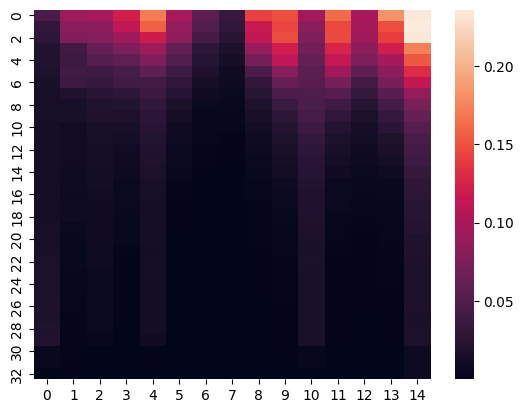

In [16]:
sns.heatmap(np_grad)

In [17]:
attribution_patching = []
for layer_idx in range(33):
    layer_name = name_pattern.format(layer_idx=layer_idx)
    contribs = (clean_state['output'][layer_name][0] - corrupted_state['output'][layer_name][0]) * corrupted_state['output'][layer_name][0].grad
    attribution_patching.append(contribs.norm(dim=-1))

<Axes: >

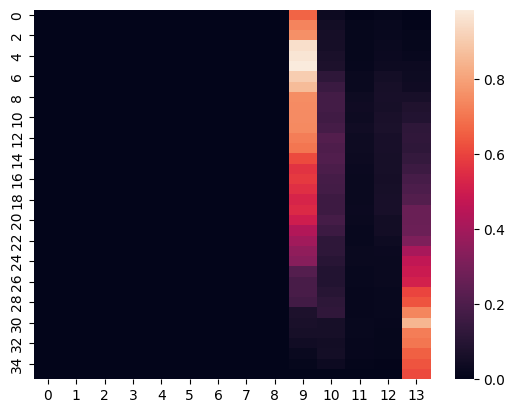

In [56]:
attribs = torch.concat(attribution_patching)
attribs_np = attribs.cpu().numpy()
sns.heatmap(attribs_np)

<Axes: >

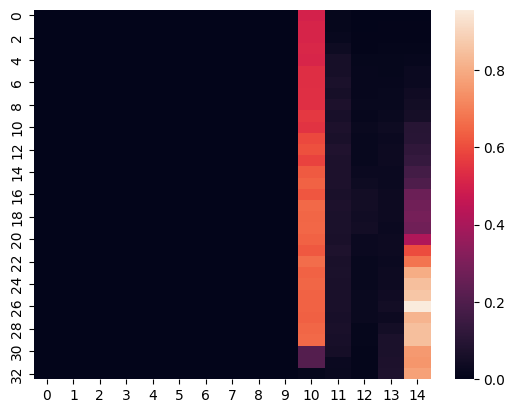

In [19]:
attribs = torch.concat(attribution_patching)
attribs_np = attribs.cpu().detach().numpy()
sns.heatmap(attribs_np)